In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TorchVision Object Detection Finetuning Tutorial
================================================


For this tutorial, we will be finetuning a pre-trained [Mask
R-CNN](https://arxiv.org/abs/1703.06870) model on the [Penn-Fudan
Database for Pedestrian Detection and
Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains
170 images with 345 instances of pedestrians, and we will use it to
illustrate how to use the new features in torchvision in order to train
an object detection and instance segmentation model on a custom dataset.

Defining the Dataset
====================

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
`torch.utils.data.Dataset`{.interpreted-text role="class"} class, and
implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__`
should return a tuple:

-   image: `torchvision.tv_tensors.Image`{.interpreted-text
    role="class"} of shape `[3, H, W]`, a pure tensor, or a PIL Image of
    size `(H, W)`
-   target: a dict containing the following fields
    -   `boxes`,
        `torchvision.tv_tensors.BoundingBoxes`{.interpreted-text
        role="class"} of shape `[N, 4]`: the coordinates of the `N`
        bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to
        `W` and `0` to `H`
    -   `labels`, integer `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: the label for each bounding box. `0` represents
        always the background class.
    -   `image_id`, int: an image identifier. It should be unique
        between all the images in the dataset, and is used during
        evaluation
    -   `area`, float `torch.Tensor`{.interpreted-text role="class"} of
        shape `[N]`: the area of the bounding box. This is used during
        evaluation with the COCO metric, to separate the metric scores
        between small, medium and large boxes.
    -   `iscrowd`, uint8 `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: instances with `iscrowd=True` will be ignored
        during evaluation.
    -   (optionally) `masks`,
        `torchvision.tv_tensors.Mask`{.interpreted-text role="class"} of
        shape `[N, H, W]`: the segmentation masks for each one of the
        objects

If your dataset is compliant with above requirements then it will work
for both training and evaluation codes from the reference script.
Evaluation code will use scripts from `pycocotools` which can be
installed with `pip install pycocotools`.

One note on the `labels`. The model considers class `0` as background.
If your dataset does not contain the background class, you should not
have `0` in your `labels`. For example, assuming you have just two
classes, *cat* and *dog*, you can define `1` (not `0`) to represent
*cats* and `2` to represent *dogs*. So, for instance, if one of the
images has both classes, your `labels` tensor should look like `[1, 2]`.

Additionally, if you want to use aspect ratio grouping during training
(so that each batch only contains images with similar aspect ratios),
then it is recommended to also implement a `get_height_and_width`
method, which returns the height and the width of the image. If this
method is not provided, we query all elements of the dataset via
`__getitem__` , which loads the image in memory and is slower than if a
custom method is provided.

Writing a custom dataset for PennFudan
--------------------------------------

Let's write a dataset for the PennFudan dataset. First, let\'s download
the dataset and extract the [zip
file](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip):

``` {.python}
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
cd data && unzip PennFudanPed.zip
```

We have the following folder structure:

    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png

Here is one example of a pair of images and segmentation masks


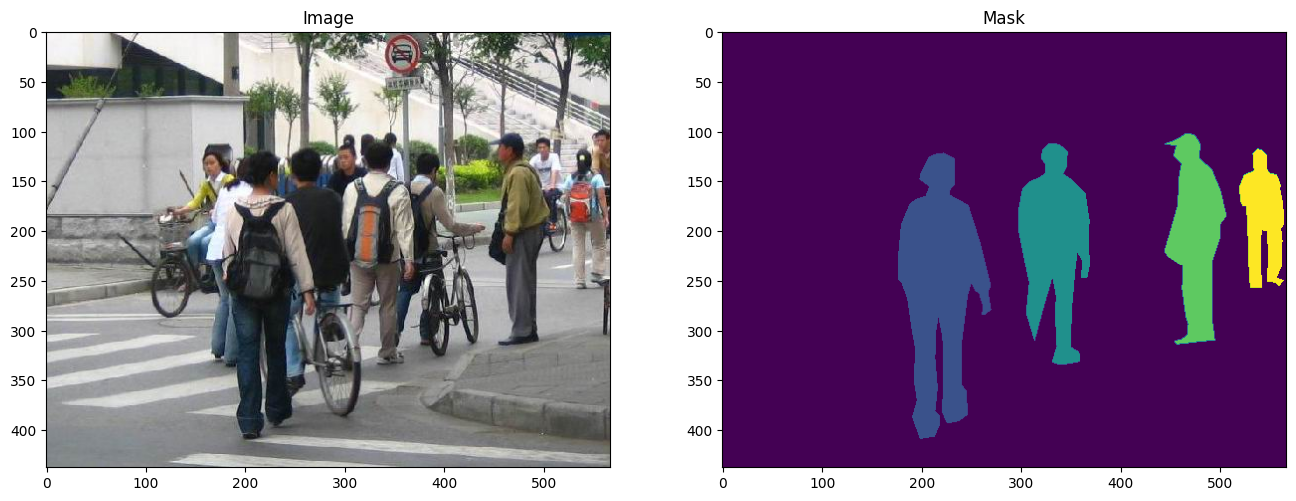

In [5]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("/content/drive/MyDrive/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("/content/drive/MyDrive/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

So each image has a corresponding segmentation mask, where each color
correspond to a different instance. Let's write a
`torch.utils.data.Dataset`{.interpreted-text role="class"} class for
this dataset. In the code below, we are wrapping images, bounding boxes
and masks into `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} classes so that we will be able to apply torchvision
built-in transformations ([new Transforms
API](https://pytorch.org/vision/stable/transforms.html)) for the given
object detection and segmentation task. Namely, image tensors will be
wrapped by `torchvision.tv_tensors.Image`{.interpreted-text
role="class"}, bounding boxes into
`torchvision.tv_tensors.BoundingBoxes`{.interpreted-text role="class"}
and masks into `torchvision.tv_tensors.Mask`{.interpreted-text
role="class"}. As `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} are `torch.Tensor`{.interpreted-text role="class"}
subclasses, wrapped objects are also tensors and inherit the plain
`torch.Tensor`{.interpreted-text role="class"} API. For more information
about torchvision `tv_tensors` see [this
documentation](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors).


In [6]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes #将分割掩码转换为边界框坐标
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset): #继承torch.utils.data.Dataset
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64) #将所有实例的标签设为 1

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Now let's define a model that can perform
predictions on this dataset.

Defining your model
===================

In this tutorial, we will be using [Mask
R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of
[Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a
model that predicts both bounding boxes and class scores for potential
objects in the image.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts
segmentation masks for each instance.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image04.png)

There are two common situations where one might want to modify one of
the available models in TorchVision Model Zoo. The first is when we want
to start from a pre-trained model, and just finetune the last layer. The
other is when we want to replace the backbone of the model with a
different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.

1 - Finetuning from a pretrained model
--------------------------------------

Let's suppose that you want to start from a model pre-trained on COCO
and want to finetune it for your particular classes. Here is a possible
way of doing it:


In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# Faster R-CNN模型，使用ResNet-50作为主干网络，并结合FPN（特征金字塔网络）处理多尺度特征
# Faster R-CNN的分类头会根据 num_classes 来决定要输出的类别数量

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
# 输入特征数，与原始分类头保持一致
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 111MB/s]


2 - Modifying the model to add a different backbone
===================================================


In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
#MobileNetV2 是一种轻量级卷积神经网络，常用于移动设备上的高效推理
backbone.out_channels = 1280 #Faster R-CNN 需要知道主干网络输出的特征图通道数

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),), #对应 32x32、64x64 等不同大小的锚框
    aspect_ratios=((0.5, 1.0, 2.0),) #height : weight
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    # 指定用于RoI Pooling的特征图名称,
    # 返回Tensor时，使用 ['0']； 返回的是 OrderedDict，可指定多个特征图
    featmap_names=['0'],
    output_size=7,    #ROI 缩放到 7 x 7
    sampling_ratio=2   #在特征图上采样的比例，用于插值
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,  # 1 class (person) + background
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 97.0MB/s]


Object detection and instance segmentation model for PennFudan Dataset
======================================================================

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:


In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    #conv5_mask 是掩码预测器中的卷积层；in_channels 表示该层的输入通道数
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256 #控制模型复杂度和性能
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

That's it, this will make `model` be ready to be trained and evaluated
on your custom dataset.

Putting everything together
===========================

In `references/detection/`, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
`references/detection/engine.py` and `references/detection/utils.py`.
Just download everything under `references/detection` to your folder and
use them here. On Linux if you have `wget`, you can download them using
below commands:


In [10]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

Since v0.15.0 torchvision provides [new Transforms
API](https://pytorch.org/vision/stable/transforms.html) to easily write
data augmentation pipelines for Object Detection and Segmentation tasks.

Let's write some helper functions for data augmentation /
transformation:


In [11]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5)) #data augmentation
    # precessing
    transforms.append(T.ToDtype(torch.float, scale=True)) #to [0,1]
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms) #将所有定义的转换操作按顺序组合成一个单一的转换对象

Testing `forward()` method (Optional)
=====================================

Before iterating over the dataset, it\'s good to see what the model
expects during training and inference time on sample data.


In [12]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,  #Scramble the order of data
    collate_fn=utils.collate_fn
    #collate_fn 自定义的拼接函数，用于将目标（字典形式）组合成批次，
    #同时保持数据的可变长性质（如不同数量的边界框和掩码
)

# For Training
images, targets = next(iter(data_loader)) #image:tensor，with shape [3, H, W]; target: dict,includes boxes,masks...
images = list(image for image in images) # Convert images to a list
#Convert targets to a list of dictionaries to maintain compatibility
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
'''
调用模型的训练接口。
输入：图像和对应的目标标注。
输出：output是包含损失值的字典，包括：
loss_classifier：分类损失。
loss_box_reg：边界框回归损失。
loss_objectness：前景/背景分类损失。
loss_rpn_box_reg：区域提案网络（RPN）损失。
'''
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
'''
调用模型的推理接口。
输入：一组张量（图像列表）。
输出：predictions 是包含检测结果的列表，每个元素为一个字典，包括：
boxes：预测的边界框坐标。
labels：预测的类别标签。
scores：每个边界框的置信分数
'''
print(predictions[0])

{'loss_classifier': tensor(0.1745, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0457, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0317, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0024, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let's now write the main function which performs the training and the
validation:


In [14]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/content/drive/MyDrive/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist() #生成一个随机序列，用于打乱数据集
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
#数据集中，前 50 个用于测试，其余作为训练集

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,#打乱
    collate_fn=utils.collate_fn #用于处理数据集中的变量长度目标（例如不同图像中目标数量不同）
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,#不打乱
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device) # CPU or GPU

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad] #从模型中筛选出需要优化的参数
optimizer = torch.optim.SGD(
    params,
    lr=0.005, #learning rate
    momentum=0.9, #减少震荡
    weight_decay=0.0005 #防止过拟合
)

# and a learning rate scheduler
# 每3个epoch将学习率乘以0.1，逐步减小以确保训练后期的稳定性
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    #执行前向和反向传播; 优化器更新模型参数; 每10次迭代打印进度
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 112MB/s]
/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:58:26  lr: 0.000090  loss: 3.6078 (3.6078)  loss_classifier: 0.6133 (0.6133)  loss_box_reg: 0.2517 (0.2517)  loss_mask: 2.7075 (2.7075)  loss_objectness: 0.0337 (0.0337)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 58.4431  data: 0.7075
Epoch: [0]  [10/60]  eta: 0:49:00  lr: 0.000936  loss: 1.7262 (2.1634)  loss_classifier: 0.4633 (0.4136)  loss_box_reg: 0.2734 (0.3473)  loss_mask: 0.8403 (1.3786)  loss_objectness: 0.0148 (0.0183)  loss_rpn_box_reg: 0.0047 (0.0055)  time: 58.8020  data: 0.4601
Epoch: [0]  [20/60]  eta: 0:39:26  lr: 0.001783  loss: 1.0184 (1.4994)  loss_classifier: 0.2176 (0.2927)  loss_box_reg: 0.2734 (0.3183)  loss_mask: 0.3498 (0.8625)  loss_objectness: 0.0150 (0.0194)  loss_rpn_box_reg: 0.0053 (0.0065)  time: 59.2071  data: 0.4674
Epoch: [0]  [30/60]  eta: 0:29:31  lr: 0.002629  loss: 0.6156 (1.2051)  loss_classifier: 0.1121 (0.2269)  loss_box_reg: 0.2884 (0.3097)  loss_mask: 0.2307 (0.6463)  loss_objectness: 0.0077 (0.0149)  loss_rpn_box_re

So after one epoch of training, we obtain a COCO-style mAP \> 50, and a
mask mAP of 65.

But what do the predictions look like? Let's take one image in the
dataset and verify


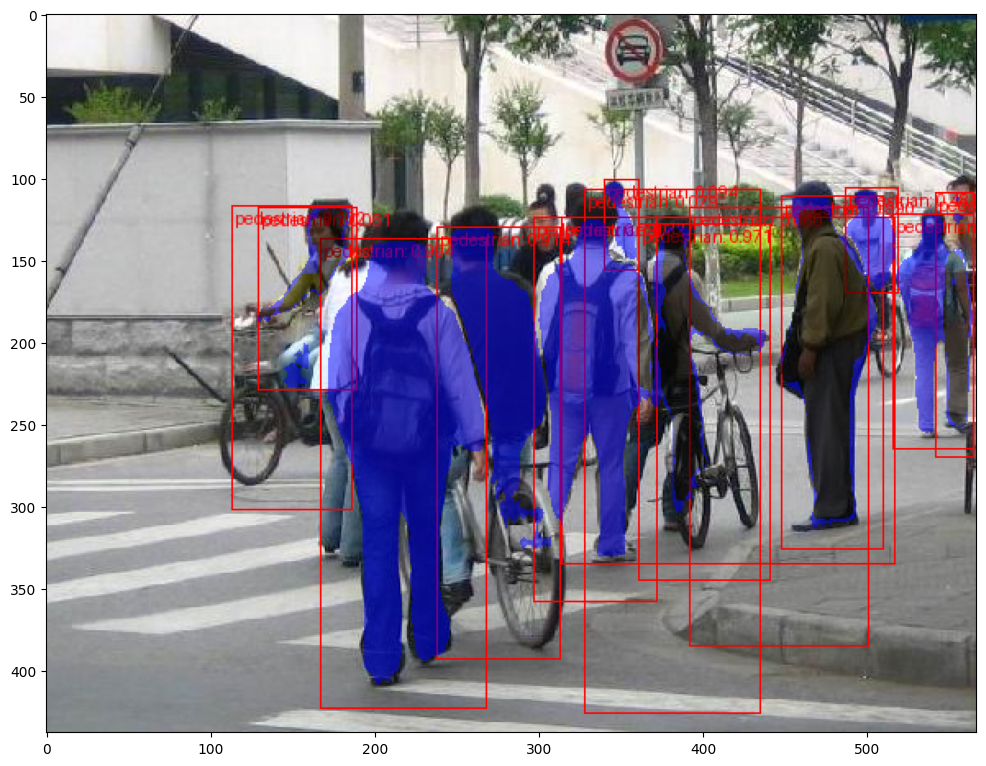

In [15]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("/content/drive/MyDrive/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False) #测试集预处理

model.eval()
with torch.no_grad(): #推理时禁用梯度计算, 减少内存消耗。
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device) #保留RGB通道数据
    predictions = model([x, ])
    pred = predictions[0] #第一个预测信息

# 将图像标准化到 [0, 255] 范围，并转为 uint8 类型以便绘制。
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
# 保留前 3 个通道（RGB）
image = image[:3, ...]
# 为每个预测生成一个标签字符串，格式保留三位小数
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# 提取预测的边界框坐标，并转换为整数（像素坐标为整数）
pred_boxes = pred["boxes"].long()
# 绘制预测的边界框
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1) #提取分割掩码中置信度大于0.7的部分，去除多余的维度，将掩码张量变为 (N, H, W)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue") #标注目标的像素区域
# alpha=0.5：掩码的透明度（0 = 完全透明，1 = 完全不透明）


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0)) # 维度调整为 (H, W, C)

The results look good!

Wrapping up
===========

In this tutorial, you have learned how to create your own training
pipeline for object detection models on a custom dataset. For that, you
wrote a `torch.utils.data.Dataset`{.interpreted-text role="class"} class
that returns the images and the ground truth boxes and segmentation
masks. You also leveraged a Mask R-CNN model pre-trained on COCO
train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU
training, check `references/detection/train.py`, which is present in the
torchvision repository.
